# ELECTROCARDIOGRAM - P-WAVE DETECTION
Hisham Ben Hamidane and Ludovic Le Reste

TBD:
- add picture for further work
- add new metric

## Load packages and files

In [32]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import signal
import time
from matplotlib.widgets import Slider

# interactivity options: ‘all’, ‘last’, ‘last_expr’ or ‘none’, ‘last_expr_or_assign’
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [33]:
# %% LOAD FILES
# path = "D:\Ludo\Docs\programming\CAS_applied_data_science\CAS-Applied-Data-Science-master\Module-6\Electrocardiogram_analysis\Assignments\ECG\www.physionet.org\physiobank\database".replace("\\", "/")
path = r"C:\Users\ludovic.lereste\Documents\CAS_applied_data_science\CAS-Applied-Data-Science-master\Module-6\Electrocardiogram_analysis\Assignments\ECG\www.physionet.org\physiobank\database".replace("\\", "/")
os.chdir(path)

record = wfdb.rdrecord("mitdb/100")
ann = wfdb.rdann("mitdb/100", "pwave")
atr = wfdb.rdann("mitdb/100", "atr")

record.__dict__
ann.__dict__.items()
atr.__dict__.items()

ecg = record.p_signal[:, 0]
ecg_v5 = record.p_signal[:, 1]

# translate discrete p-wave annotation into digital signal
# p-wave is +-width around annotation
p_ts = np.zeros(record.sig_len, dtype=int)
width = 6
for i in ann.sample:
    p_ts[max(i-width, 0):min(i+width, record.sig_len)] = 1
    
# translate discrete r-wave annotation into digital signal
# r-wave is +-width around annotation
r_ts = np.zeros(record.sig_len, dtype=int)
width = 6
for i in atr.sample:
    r_ts[max(i-width, 0):min(i+width, record.sig_len)] = 1

# Generate time vector
fq = 360
t = np.linspace(start=0, stop=ecg.size/fq, num=ecg.size)
tss = np.vstack((t, ecg, p_ts)).T

## Data exploration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


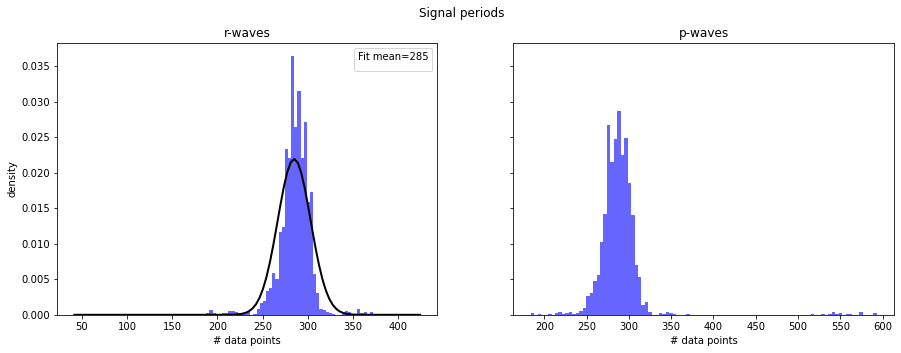

There are 1 r-wave periods longer than 400 data points
There are 16 p-wave periods longer than 400 data points


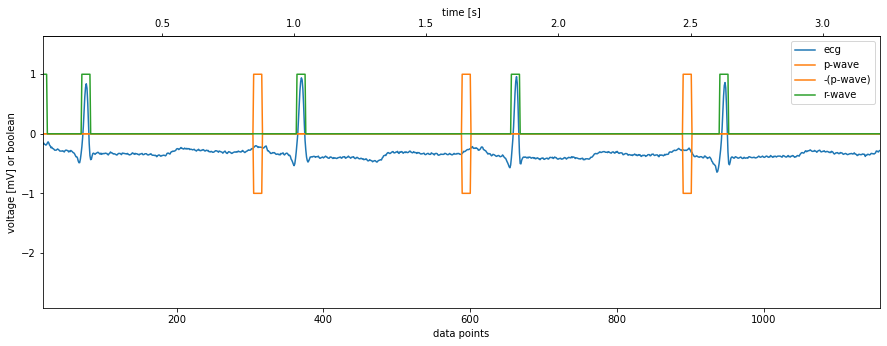

In [41]:
# %% EXPLORE DATA
# Analyse heartbeats periods
period = np.diff(atr.sample)
period_p = np.diff(ann.sample)

# Fit a normal distribution to period distribution
mu, std = norm.fit(period) 
period_mean = int(mu)
  
mu_p, std_p = norm.fit(period_p) 
period_mean_p = int(mu_p)

# Plot the histogram and Probability Density Function.
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

axs[0].hist(period, bins=100, density=True, alpha=0.6, color='b')
x_min, x_max = axs[0].get_xlim()
x_prob = np.linspace(x_min, x_max, 100)
prob = norm.pdf(x_prob, period_mean, std)
axs[0].plot(x_prob, prob, 'k', linewidth=2)
axs[0].set_xlabel('# data points')
axs[0].set_ylabel('density')
axs[0].legend(title=f"Fit mean={period_mean}")
axs[0].set_title("r-waves")

axs[1].hist(period_p, bins=100, density=True, alpha=0.6, color='b')
axs[1].set_xlabel('# data points')
axs[1].set_title('p-waves')

fig.suptitle('Signal periods')
plt.show()

"""
N.B.:
    There are a few (16) heartbeats with no p-wave annotated
    There is only one weird heartbeat (lasting 407 samples: heartbeat # 1907)
"""
print(f"There are {np.count_nonzero(period > 400)} r-wave periods longer than 400 data points")
print(f"There are {np.count_nonzero(period_p > 400)} p-wave periods longer than 400 data points")

# Plot time series
n_samples = period_mean*4
heartbeats = np.where(period>00)[0]
case = 1
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ecg, label='ecg')
ax.plot(p_ts, label='p-wave')
ax.plot(p_ts*-1, label='-(p-wave)', color='C1')
ax.plot(r_ts, label='r-wave')
ax.set_xlim([atr.sample[heartbeats[case]-1], atr.sample[heartbeats[case]-1]+ n_samples])
# plt.xlim([0, n_samples])
ax.set_xlabel('data points')
ax.set_ylabel('voltage [mV] or boolean')
secax = ax.secondary_xaxis('top', functions=(lambda x: x/fq, lambda x: x*fq))
secax.set_xlabel('time [s]')
ax.legend()
plt.show()

## Prepare data for neural networks
1- split time series into chunks of same size (called packets)
* The start index of each packet is chosen randomly
    
2- split the packets for training and test

In [35]:
# %% PREP DATA
"""
Split data into packets of same length to feed to the model
The start of the chunk isi randomly chosen
remove the first (weird annotation) and the last two heartbeats (for dimension consistency)
"""
packet_length = 285
sampling = 2
packet_length_ds = ecg[: packet_length : sampling].shape[0]
ecg_packets = np.zeros(shape=(int(ecg.shape[0]/packet_length), packet_length_ds))
p_ts_packets = np.zeros(shape=ecg_packets.shape, dtype=int)

rng = np.random.default_rng(42)
ints = rng.integers(low=0, high=ecg.size-packet_length, size=ecg_packets.shape[0])

for i in range(ecg_packets.shape[0]):
    ecg_packets[i, :] = ecg[ints[i] : ints[i]+packet_length : sampling]
    p_ts_packets[i, :] = p_ts[ints[i] : ints[i]+packet_length : sampling]

# split train, test
perc_split = 0.8
n_inputs = ecg_packets.shape[0]
ecg_packets_train = ecg_packets[0:int(n_inputs*perc_split)]
ecg_packets_test = ecg_packets[int(n_inputs*perc_split):-1]
p_ts_packets_train = p_ts_packets[0:int(n_inputs*perc_split)]
p_ts_packets_test = p_ts_packets[int(n_inputs*perc_split):-1]

## Dense neural networks
### Model

In [36]:
# %% MODEL 2: Dense neural network - 2 layers
tf.keras.backend.clear_session()
# Build model
d_mult = 1.2

d_input = ecg_packets.shape[1]
x = tf.keras.layers.Input(dtype='float64', shape=d_input)

lay_1 = tf.keras.layers.Dense(units=int(d_input*d_mult), activation='relu', name='L1')(x)
lay_2 = tf.keras.layers.Dense(units=d_input, activation='sigmoid', name='L2')(lay_1)

#prediction: probability->integer
# pred = 

#TBD: adding pred to the model output prudces an error (expected int64, instead had float)
model = tf.keras.Model(inputs=x, outputs=[lay_2])

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 143)]             0         
_________________________________________________________________
L1 (Dense)                   (None, 171)               24624     
_________________________________________________________________
L2 (Dense)                   (None, 143)               24596     
Total params: 49,220
Trainable params: 49,220
Non-trainable params: 0
_________________________________________________________________


In [37]:
# %% TRAIN MODEL
batch_size = 50

start = time.time()
hist = model.fit(x=ecg_packets_train,
                    y=p_ts_packets_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(ecg_packets_test, p_ts_packets_test))
print(time.time()-start)

Epoch 1/50
37/37 [==============================] - 1s 9ms/step - loss: 0.3445 - binary_accuracy: 0.9003 - precision: 0.0405 - recall: 0.0611 - val_loss: 0.1885 - val_binary_accuracy: 0.9588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 0s 2ms/step - loss: 0.1803 - binary_accuracy: 0.9582 - precision: 0.2143 - recall: 2.7531e-04 - val_loss: 0.1730 - val_binary_accuracy: 0.9588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
37/37 [==============================] - 0s 2ms/step - loss: 0.1716 - binary_accuracy: 0.9582 - precision: 0.2000 - recall: 2.7531e-04 - val_loss: 0.1662 - val_binary_accuracy: 0.9588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 0.1626 - binary_accuracy: 0.9582 - precision: 0.3846 - recall: 4.5884e-04 - val_loss: 0.1556 - val_binary_accuracy: 0.9588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
3

37/37 [==============================] - 0s 2ms/step - loss: 0.0559 - binary_accuracy: 0.9757 - precision: 0.7439 - recall: 0.6367 - val_loss: 0.0609 - val_binary_accuracy: 0.9736 - val_precision: 0.7166 - val_recall: 0.5937
Epoch 36/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0556 - binary_accuracy: 0.9756 - precision: 0.7449 - recall: 0.6317 - val_loss: 0.0604 - val_binary_accuracy: 0.9738 - val_precision: 0.7088 - val_recall: 0.6187
Epoch 37/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0553 - binary_accuracy: 0.9758 - precision: 0.7452 - recall: 0.6392 - val_loss: 0.0603 - val_binary_accuracy: 0.9739 - val_precision: 0.7192 - val_recall: 0.6004
Epoch 38/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0550 - binary_accuracy: 0.9758 - precision: 0.7463 - recall: 0.6368 - val_loss: 0.0600 - val_binary_accuracy: 0.9738 - val_precision: 0.7045 - val_recall: 0.6265
Epoch 39/50
37/37 [==============================] - 0s 2ms/step

### Results

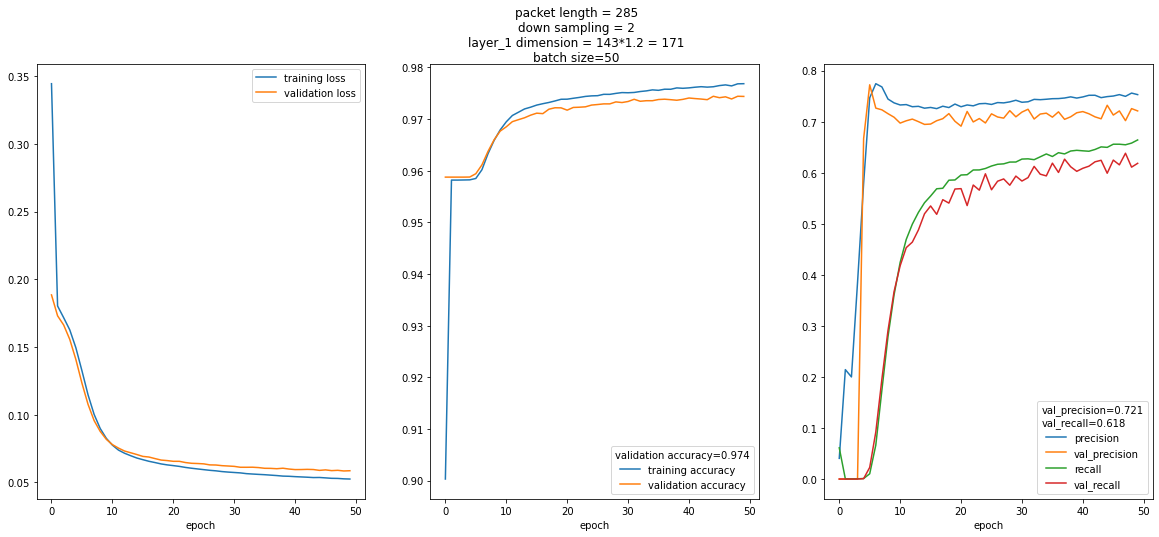

In [38]:
# %% PLOT RESULTS
"""N.B.: hist.params['batch_size'] does not work on Thermo's PC"""
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[0].set_xlabel('epoch')

axs[1].plot(hist.epoch, hist.history['binary_accuracy'])
axs[1].plot(hist.epoch, hist.history['val_binary_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'),
              title=f"validation accuracy={hist.history['val_binary_accuracy'][-1]:.3f}",
              loc='lower right')
axs[1].set_xlabel('epoch')

axs[2].plot(hist.epoch, hist.history['precision'])
axs[2].plot(hist.epoch, hist.history['val_precision'])
axs[2].plot(hist.epoch, hist.history['recall'])
axs[2].plot(hist.epoch, hist.history['val_recall'])
axs[2].legend(('precision', 'val_precision',
               'recall', 'val_recall'),
              title=f"val_precision={hist.history['val_precision'][-1]:.3f}\n"
              f"val_recall={hist.history['val_recall'][-1]:.3f}",
              loc='lower right')
axs[2].set_xlabel('epoch')

fig.suptitle(f"packet length = {packet_length}\n"
             f"down sampling = {sampling}\n"
             f"layer_1 dimension = {d_input}*{d_mult} = {int(d_input*d_mult)}\n"
             f"batch size={batch_size}")
plt.show()

![diagram showing presision and recall](precision_recall_diagram.png "precision and recall diagram")

In [39]:
# %% EXAMINE RESULTS
from ipywidgets import interact

data = ecg_packets_test
data_ann = p_ts_packets_test
pred_test = model.predict(data)

n_rows = 4
n_cols = 6
n_plots = n_rows * n_cols

@interact
# def plot_packets(n_pack=(0, n_plots, data.shape[0]-n_plots)):
def plot_packets(n_pack=(0, 324, 24)):
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(25,15))
    # plt.get_current_fig_manager().window.state('zoomed')
    # plt.subplots_adjust(top=0.90)

    for i, ax in enumerate(axs.flat):
        ax.plot(data[i+n_pack, :])
        ax.plot(data_ann[i+n_pack, :])
        ax.plot(data_ann[i+n_pack, :]*-1, color='C1')
        ax.plot(pred_test[i+n_pack, :])
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_ylim(ymin=-1.2, ymax=1.3)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


interactive(children=(IntSlider(value=144, description='n_pack', max=324, step=24), Output()), _dom_classes=('…

Some annotations are worth discussing...
![Annotations](Annotations_discussion.png "Annotations to discuss")

Parameters impacting the model
* 2 layers is much better than 1 layer, even with small size of first layer
    * best results for size=1.2 to 1.5 * the number of data points (1.5x shows more overfitting, looking at the gap between train and test accuracy)
* size of the packet
    - size around signal period gives best results
    - small window gives worst results
    - longer window requires layers size too big
* down sampling
    - slightly worst accuracy for down sampling > 2
* batch size has little influence

Discussion on metrics
* metric based on blocks/annotation instead of metric computed for each data point

# Convolutional neural network
## Model 1

In [ ]:
# %% Convolutional NN
# MODEL 1: Convolution neural network

## input x defined as previously with dimensions (number of training bins x target sampling)
x = tf.keras.layers.Input(dtype='float64', shape=(sample_size, 1))
## Reshaping the training and testing input x so that each vector of n elements is now a list of n elements (in R linguo)
train_x_rs = tf.reshape(train_x,(train_x.shape[0], sample_size, 1))
train_y_rs = tf.reshape(train_y, (train_y.shape[0], sample_size, 1))
test_x_rs = tf.reshape(test_x,(test_x.shape[0], sample_size, 1))
test_y_rs = tf.reshape(test_y, (test_y.shape[0], sample_size, 1))
# defining global parameters for the convolutional layers
stride = 1
dilation = 1

# Defining the convolutional neural networs
## 1. convolutional layers
## convolution layers accpet input with shape (*,1); 1st argument is number of filters, 2nd argument kernel size (here 1D) 
C1 = tf.keras.layers.Conv1D(100, sample_size, padding = 'same', activation ='relu', input_shape= (None, sample_size, 1), name = 'C1')(x) 
C2 = tf.keras.layers.Conv1D(50, int(sample_size/2), padding = 'same', activation ='relu', name = 'C2')(C1)
# 2. Pooling layer; pooling by groups of pool_size, using padding = 'same' to retain the input dimensions
#P1 = tf.keras.layers.MaxPool1D(pool_size=int(target_sampling/3), strides=stride, padding='same', name = 'P1')(C2)
# 3. convolutional layer, higher filter count, reduced kernel size
#C3 = tf.keras.layers.Conv1D(int(target_sampling/5), 3, padding = 'same', activation = 'relu', name = 'C3')(P1)
# 4. flatten layer; not needed as long as input (x) dimensions are maintained through the use of padding (argument ='same')
#F1 = tf.keras.layers.Flatten()(C3)
# 5. dense layer 1 and 2 to apply classical NN computations on convoluted input
D1 = tf.keras.layers.Dense(units=int(sample_size/3), activation = 'relu', name='D1')(C2)
#D2 = tf.keras.layers.Dense(units=sample_size, activation = 'relu', name='D2')(D1)
D3 = tf.keras.layers.Dense(units=1, activation = 'sigmoid', name = 'D3')(D1)

## definition
model = tf.keras.Model(inputs=x, outputs=[D3])

# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

## visualization
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# test the model accuracy
hist = model.fit(x=train_x_rs,
                 y=train_y_rs,
                 epochs=50,
                 batch_size=int(train_idx_count/5),
                 validation_data=(test_x_rs, test_y_rs))

## Ideas for further work

Before feeding raw data to the neural network, one could transform the data and feed the raw and transformed data to the model.

Ideas to transform the data below:
- filtered signal
- spectrogram

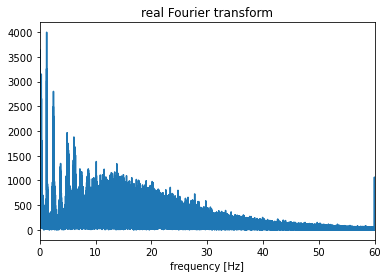

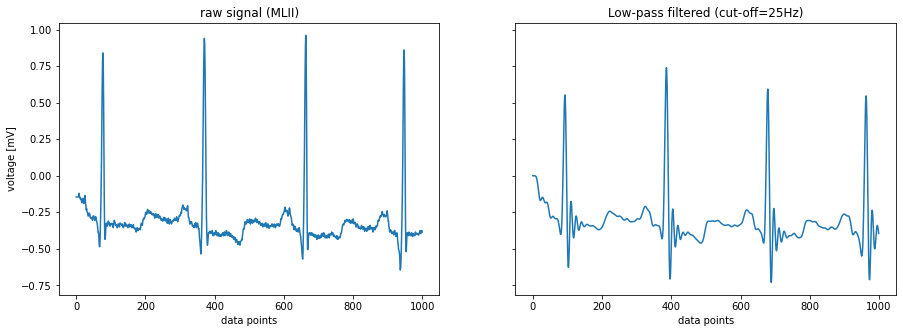

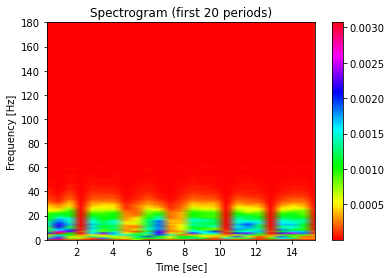

In [40]:
# Fourier transform
ecg_ft = np.fft.rfft(ecg)
f = np.fft.rfftfreq(ecg.size, d=1/fq)
plt.figure()
plt.plot(f[1:], np.abs(ecg_ft[1:]))
plt.xlim([0, 60])
plt.xlabel('frequency [Hz]')
plt.title('real Fourier transform')

# Filtering frequencies
# sos = signal.butter(N=10, Wn=[fq/50000, fq/50], btype='bandpass', output='sos', fs=fq)
cutoff=25
sos = signal.butter(N=10, Wn=cutoff, btype='lowpass', output='sos', fs=fq)
ecg_f = signal.sosfilt(sos, ecg)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,5))
axs[0].plot(ecg[:1000])
axs[0].set_xlabel('data points')
axs[0].set_ylabel('voltage [mV]')
axs[0].set_title(f'raw signal (MLII)')
axs[1].plot(ecg_f[:1000])
axs[1].set_xlabel('data points')
axs[1].set_title(f'Low-pass filtered (cut-off={cutoff}Hz)')
plt.show()

# Spectrogram
fig, ax = plt.subplots()
spec_f, spec_t, spec_map = signal.spectrogram(ecg[:20*period_mean], fq)
pcm = ax.pcolormesh(spec_t, spec_f, spec_map, shading='gouraud', cmap='hsv')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_title('Spectrogram (first 20 periods)')
fig.colorbar(pcm, ax=ax)